In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
def findFiles(path): return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

train = {}
test = {}
allline = []
for filename in findFiles('/content/drive/My Drive/Colab Notebooks/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    train[category] = category_lines[category][0 : int(0.9*len(category_lines[category]))]
    test[category] = category_lines[category][int(0.9*len(category_lines[category])):]

n_categories = len(all_categories)

In [0]:
import torch

letter_indices = {char: idx for idx, char in enumerate(all_letters)}

max_len = max([max([len(word) for word in category_lines[ca]]) for ca in all_categories])

def lineToTensor(line):
    tensor = torch.zeros(max_len, n_letters)
    for li, letter in enumerate(line):
        tensor[li][letter_indices[letter]] = 1
    return tensor

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_size, max_seq_len):
        super(RNN, self).__init__()
        self.maxlen = max_seq_len
        self.i2o = nn.Linear(hidden_sz * hidden_sz, output_size)
        self.rnn = nn.RNN(input_sz, hidden_sz, batch_first=True)

    def forward(self, input, line_lengths):
        input = torch.nn.utils.rnn.pack_padded_sequence(input, line_lengths, batch_first=True)

        output, hidden = self.rnn(input)
        
        output_padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, total_length=self.maxlen, batch_first=True)
        output = output_padded.contiguous()
        output = output.view(output.shape[0], -1)
        
        output = self.i2o(output)
        output = F.log_softmax(output, dim=1)
        
        return output

rnn = RNN(n_letters, max_len, n_categories, max_len)

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [0]:
import random

def categChoice(l):
    return l[random.randint(0, len(l)-1)]
  
def trainChoice(l):
    return l[random.randint(0, int(len(l)*0.9) - 1)]

def testChoice(l):
    return l[random.randint(int(len(l)*0.9), len(l) - 1)]

def randomTrainingExample():
    category = categChoice(all_categories)
    line = trainChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestExample():
    category_list = []
    line_list = []
    category_tensor_batch = [] 
    line_tensor_batch = []
    line_lens = []
    list_to_sort = []
    category = categChoice(all_categories)
    line = testChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    for i in range(10):
      category, line, category_tensor, line_tensor = randomTrainingExample()
      line_len = (line_tensor>0).sum()
      list_to_sort.append((category,line,category_tensor,line_tensor,line_len))        
    sorted_list = sorted(list_to_sort, key=lambda line:line[4], reverse=True)
    for line in sorted_list:
      category, line, category_tensor, line_tensor, line_len = line
      category_list.append(category)
      line_list.append(line)
      category_tensor_batch.append(category_tensor.item())
      line_tensor_batch.append(line_tensor)
      line_lens.append(line_len)
    return category_list, line_list, torch.tensor(category_tensor_batch), torch.stack(line_tensor_batch), torch.stack(line_lens)
    
def batch(num):
    category_list = []
    line_list = []
    category_tensor_batch = [] 
    line_tensor_batch = []
    line_lens = []
    list_to_sort = []
    
    for i in range(num):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        line_len = (line_tensor>0).sum()
        list_to_sort.append((category,line,category_tensor,line_tensor,line_len))
        
    sorted_list = sorted(list_to_sort, key=lambda line:line[4], reverse=True)
    
    for line in sorted_list:
        category, line, category_tensor, line_tensor, line_len = line
        category_list.append(category)
        line_list.append(line)
        category_tensor_batch.append(category_tensor.item())
        line_tensor_batch.append(line_tensor)
        line_lens.append(line_len)
    return category_list, line_list, torch.tensor(category_tensor_batch), torch.stack(line_tensor_batch), torch.stack(line_lens) # only one can use torch.tensor so used .stack

In [0]:
criterion = nn.NLLLoss()

In [0]:
def train(category_tensor_batch, line_tensor_batch, line_lengths, learning_rate):
    rnn.zero_grad()
    output = rnn(line_tensor_batch, line_lengths)
    loss = criterion(output, category_tensor_batch)
    loss.backward()

    #Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    return output, loss.item()

In [356]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

learning_rate = 0.005
current_loss = 0
all_losses = []

start = time.time()
for epoch in range(1, 50001):
  category_list, line_list, category_tensor_batch, line_tensor_batch, line_lengths = batch(64)
  output, batch_loss = train(category_tensor_batch, line_tensor_batch, line_lengths,learning_rate)
  current_loss += batch_loss

  if epoch % 5000 == 0:
    guess, guess_i = categoryFromOutput(output[0])
    category = category_list[0]
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / 50000 * 100, timeSince(start), batch_loss, line_list[0], guess, correct))
  if epoch % 1000 == 0:
    all_losses.append(current_loss / 500)
    current_loss = 0

5000 10% (1m 0s) 2.1285 Konstantatos / Greek ✓
10000 20% (2m 1s) 1.8447 Balanchivadze / Italian ✗ (Russian)
15000 30% (3m 2s) 1.8255 Sakellariou / Polish ✗ (Greek)
20000 40% (4m 4s) 1.8039 Katsourinis / Greek ✓
25000 50% (5m 7s) 1.6464 Rooijakkers / Greek ✗ (Dutch)
30000 60% (6m 7s) 1.8213 Hadjiyianakies / Greek ✓
35000 70% (7m 8s) 1.5956 Michalovicova / Russian ✗ (Czech)
40000 80% (8m 8s) 1.2258 Schneijders / Dutch ✓
45000 90% (9m 10s) 1.2757 Williamson / Scottish ✓
50000 100% (10m 12s) 1.3004 Featherstone / French ✗ (English)


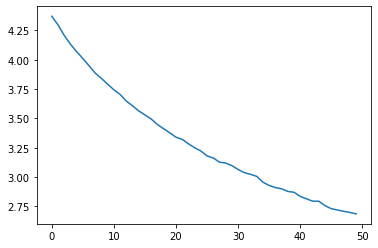

In [357]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

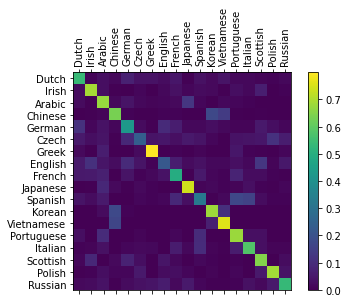

In [421]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

for i in range(n_confusion):
    category_list, line_list, category_tensor_batch, line_tensor_batch, line_lengths = randomTestExample()
    output = rnn(line_tensor_batch, line_lengths)
    for j in range(0, 10):
      guess, guess_i = categoryFromOutput(output[j])
      category_i = all_categories.index(category_list[j])
      confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()